<a href="https://colab.research.google.com/github/royam0820/DL/blob/master/Copy_of_malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Medical Image Analysis for Malaria
Malaria.  Learn to classify blood smear images using a high-level deep learning environment.

References:


[1] https://www.who.int/news-room/fact-sheets/detail/malaria

[2] https://www.cdc.gov/malaria/diagnosis_treatment/diagnosis.html

[3] https://towardsdatascience.com/deep-learning-and-medical-image-analysis-for-malaria-detection-with-fastai-c8f08560262f

In [0]:
!/opt/bin/nvidia-smi
!nvcc --version

Thu Jul 11 09:29:51 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import fastai
import gc
import torch
print(f'fastai: {fastai.__version__}')
print(f'cuda: {torch.cuda.is_available()}')

fastai: 1.0.54
cuda: True


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import SaveModelCallback
# Imports for diverse utilities
from shutil import copyfile
import matplotlib.pyplot as plt
import operator
from PIL import Image
from sys import intern   # For the symbol definitions

# Utility functions - Export and Restoration Functions

In [0]:
# Export network for deployment and create a copy
def exportStageTo(learn, path):
    learn.export()
    # Faça backup diferenciado
    copyfile(path/'export.pkl', path/'export-malaria.pkl')
    
#exportStage1(learn, path)


In [0]:
# Restoration of a deployment model, for example in order to conitnue fine-tuning
def restoreStageFrom(path):
  # Restore a backup
  copyfile(path/'export-malaria.pkl', path/'export.pkl')
  return load_learner(path)
  
#learn = restoreStage1From(path)

# The Malaria dataset 
The task is inspired by the project of the Communications Engineering Branch (CEB) of the Lister Hill National Center for Biomedical Communications, an R&D division of the U.S. National Library of Medicine. The dataset provided is balanced — consists of a total of **27,558 cell images** with equal instances of parasitized (infected) and uninfected (clean) cells. 

For the model training/validation the data set was split in 80/20 ratio.

## Downloading the Malaria Dataset

In [0]:
!mkdir malaria

In [0]:
!wget  --backups=1 -q https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip -P malaria
!wget  --backups=1 -q https://ceb.nlm.nih.gov/proj/malaria -P malaria #/malaria_cell_classification_code.zip


In [0]:
# List what you've downloaded:
!ls -al

total 20
drwxr-xr-x 1 root root 4096 Jul 11 09:30 .
drwxr-xr-x 1 root root 4096 Jul 11 09:28 ..
drwxr-xr-x 1 root root 4096 Jul  3 16:14 .config
drwxr-xr-x 2 root root 4096 Jul 11 09:30 malaria
drwxr-xr-x 1 root root 4096 Jul  3 16:14 sample_data


In [0]:
!unzip /content/malaria/cell_images.zip -d /content/malaria

In [0]:
!apt install tree

In [0]:
# listing only the directories
!tree /content/malaria -d

/content/malaria
└── cell_images
    ├── Parasitized
    └── Uninfected

3 directories


# Resnet34

## Initialize a few variables

- batch size (bs) = 256
- image size (size) = 128
- path = Path('./malaria/')

In [0]:
bs = 256        # Batch size, 256 for small images on a T4 GPU...
size = 128      # Image size, 128x128 is a bit smaller than most 
                # of the images...
path = Path("./malaria/")   # The path to the 'train' folder you created...

In [0]:
path.ls()

[PosixPath('malaria/cell_images.zip')]

## Applying Tranformations
no warp, no rotation, and a max_zoom set to 1.0.

Ref.: [Fastai Image Transformations](https://docs.fast.ai/vision.transform.html)



In [0]:
tfms = get_transforms(max_rotate=None, max_warp=None, flip_vert=True, max_zoom=1.0)

## Create the Databunch

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='cell_images', ds_tfms=tfms, size=size, valid_pct=0.2, bs=bs
                                  ).normalize(imagenet_stats)

In [0]:
data.classes

['Parasitized', 'Uninfected']

In [0]:
# print the statistics for the classes: Parasitized and Uninfected
data

ImageDataBunch;

Train: LabelList (22047 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Uninfected,Uninfected,Uninfected,Uninfected,Uninfected
Path: malaria;

Valid: LabelList (5511 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Uninfected,Uninfected,Parasitized,Parasitized,Parasitized
Path: malaria;

Test: None

NOTE:  `data` ‘will simply output the return value of the ImageDataBunch instance:

- We have for the train dataset 22047 items.
- We have for the validation dataset 5511 items
- image size 128 x 128 pixels
- 3 channels (RGB)
- x axis = image
- y axis = the label


## Show the batch

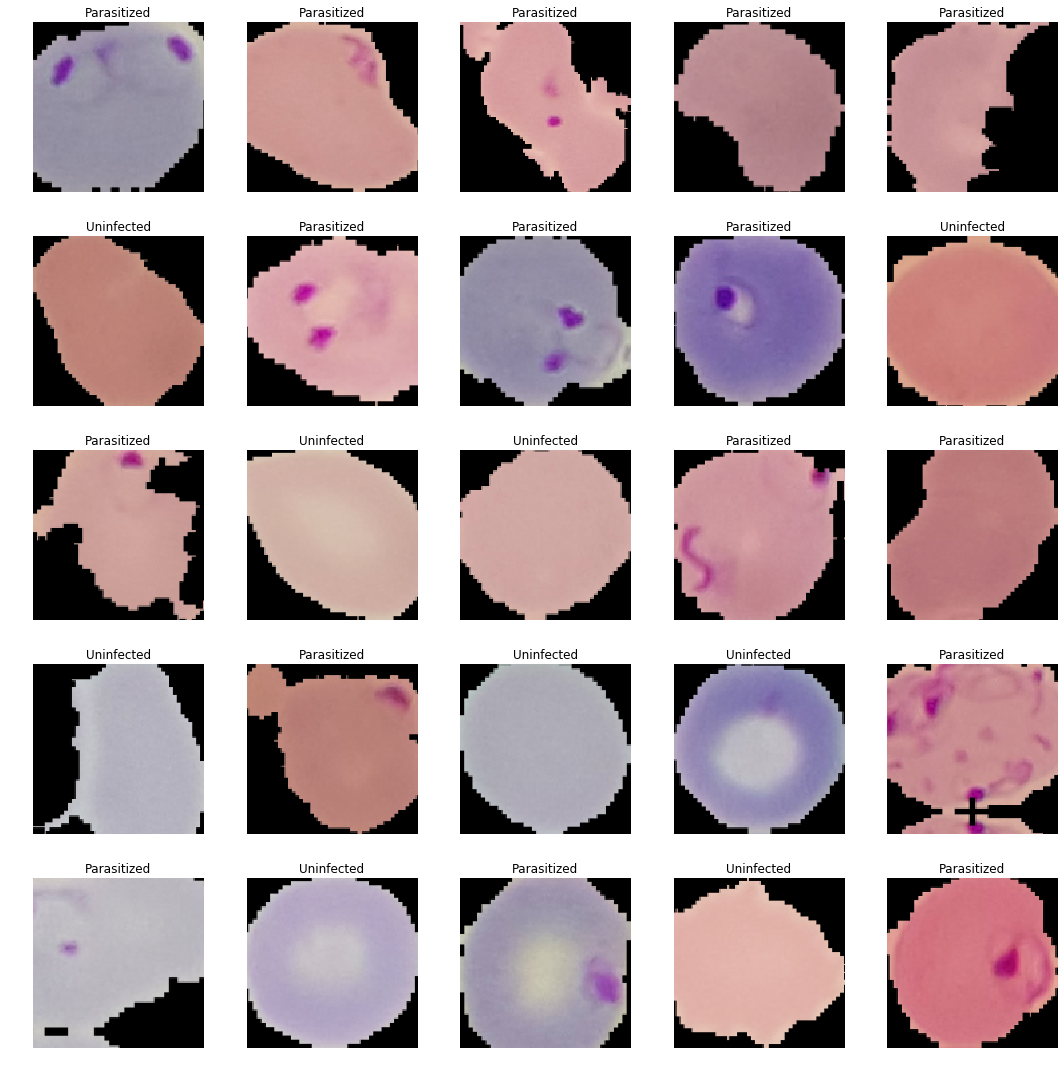

In [0]:
data.show_batch(rows=5, figsize=(15,15))

## Save the databunch

In [0]:
# save the databunch
data.save('/content/malaria/imageDataBunch-bs-'+str(bs)+'-size-'+str(size)+'.pkl')

## Training with Resnet34
Resnet34 (Residual Network with 34 layers) is a good choice to start with.

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy], wd=0.1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 27325552.68it/s]


In [0]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
___________________________________________________

## The Learning rate finder

The method `learn.lr_find()` helps you find an optimal learning rate. 

It uses the technique developed in the [ 2015 paper Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186) where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.



In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.09E-03
Min loss divided by 10: 3.02E-02


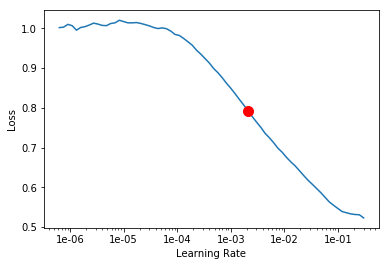

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
lr = 1e-3

In [0]:
learn.fit_one_cycle(4,max_lr=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.373547,0.147898,0.052622,0.947378,01:39
1,0.205593,0.115612,0.044275,0.955725,01:37
2,0.160326,0.107139,0.038650,0.961350,01:33
3,0.141811,0.106049,0.038106,0.961894,01:33


## Show the learning curve
It is interesting to look at the learning and the validation curves. It will show us if the network has learned in a steady way or if it oscillated (which can indicate bad quality data) and if we have a result that is OK or if we are overfitting or underfitting our network.

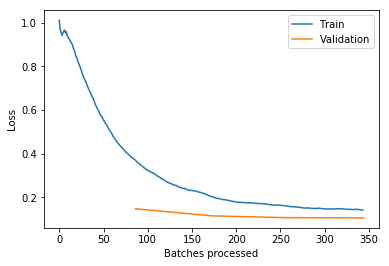

In [0]:
learn.recorder.plot_losses()

In [0]:
# let's save the trained model
learn.save('/content/malaria/malaria-stage-1')

## Analyzing the results

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

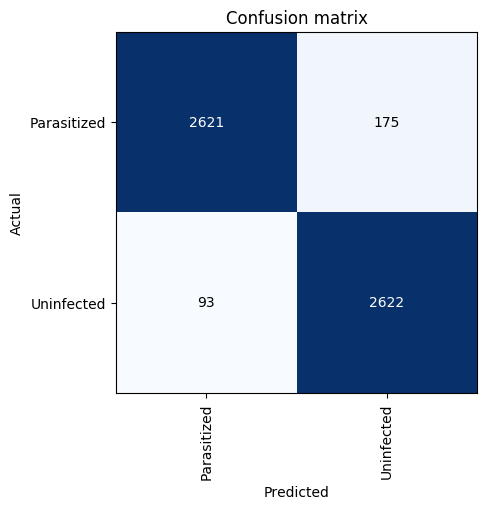

In [0]:
# The confusion matrix
interp.plot_confusion_matrix(figsize=(5,5), dpi=100)

NOTE: This means:

-  93 out of 2715  infected cells were classified as clean — False Negative;
-  175 out of 2796 clean cells were classified as infected — False Positive.

In [0]:
# another way to display the most confused labels
interp.most_confused(min_val=2)

[('Parasitized', 'Uninfected', 175), ('Uninfected', 'Parasitized', 93)]

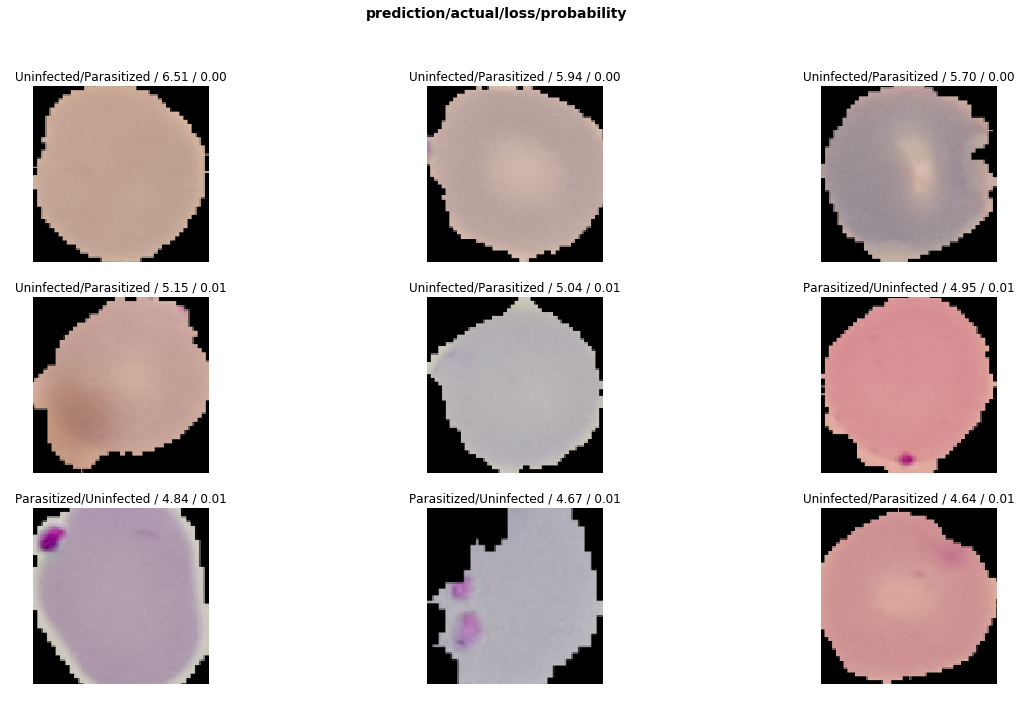

In [0]:
# look at the 9 worst results
interp.plot_top_losses(9, figsize=(20,11), heatmap=False)

NOTE: Looking at the ResNet-34 Incorrectly classified images, we may conclude that some of the images in fact may be incorrectly labeled in the dataset — those which are clearly infected are labeled as clean and vice versa!


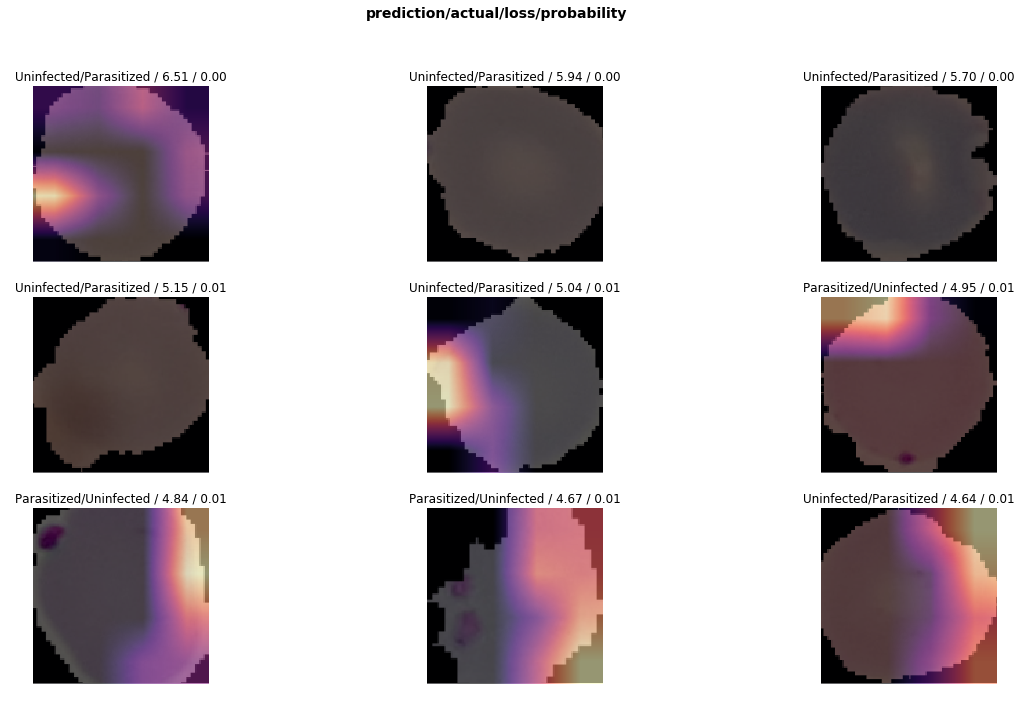

In [0]:
# Now, do the same but highlight using a heatmap to highligh the wrong classification
interp.plot_top_losses(9, figsize=(20,11), heatmap=True)

## Fine Tuning - Unfreezing the model

In [0]:

learn.unfreeze()

In [0]:
learn.summary()


Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
___________________________________________________

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.91E-05


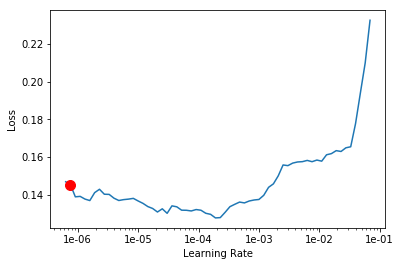

In [0]:
learn.recorder.plot(suggestion=True)

NOTE: when you unfreeze,  look at the chart, find the bottom line, go 10x smaller (beginning of the slice), then for the end of the slice, take the origninal lr (when model frozen), then divide the original lr /5.

Concerning `max_lr=slice(start, end)`, it means, train the first layers with a LR of start; the last layers at a LR of end; and for the remaining layers, spread the LR across the range (start, end).


In [0]:
learn.fit_one_cycle(4,max_lr=slice(1e-5,lr/5))


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.128276,0.118324,0.045001,0.954999,01:39
1,0.118600,0.106419,0.039013,0.960987,01:41
2,0.108262,0.101008,0.037380,0.962620,01:41
3,0.099529,0.098965,0.037198,0.962802,01:41


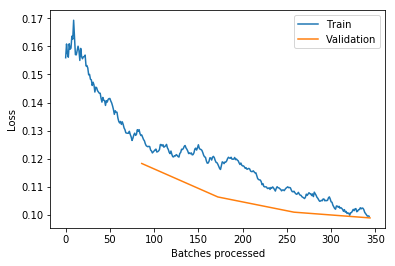

In [0]:
learn.recorder.plot_losses()

In [0]:
# let's save the trained model
learn.save('/content/malaria/malaria-stage-2')

## Analyze the results

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

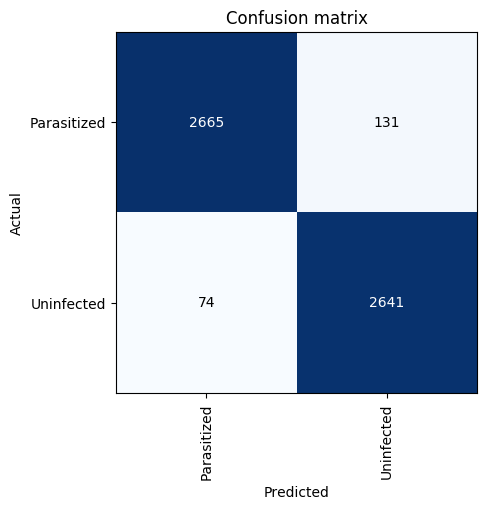

In [0]:
# The confusion matrix
interp.plot_confusion_matrix(figsize=(5,5), dpi=100)

NOTE:  This means:

-  74 out of 2715 infected cells were classified as clean — False Negative;
-  131 out of 2796 clean cells were classified as infected — False Positive.



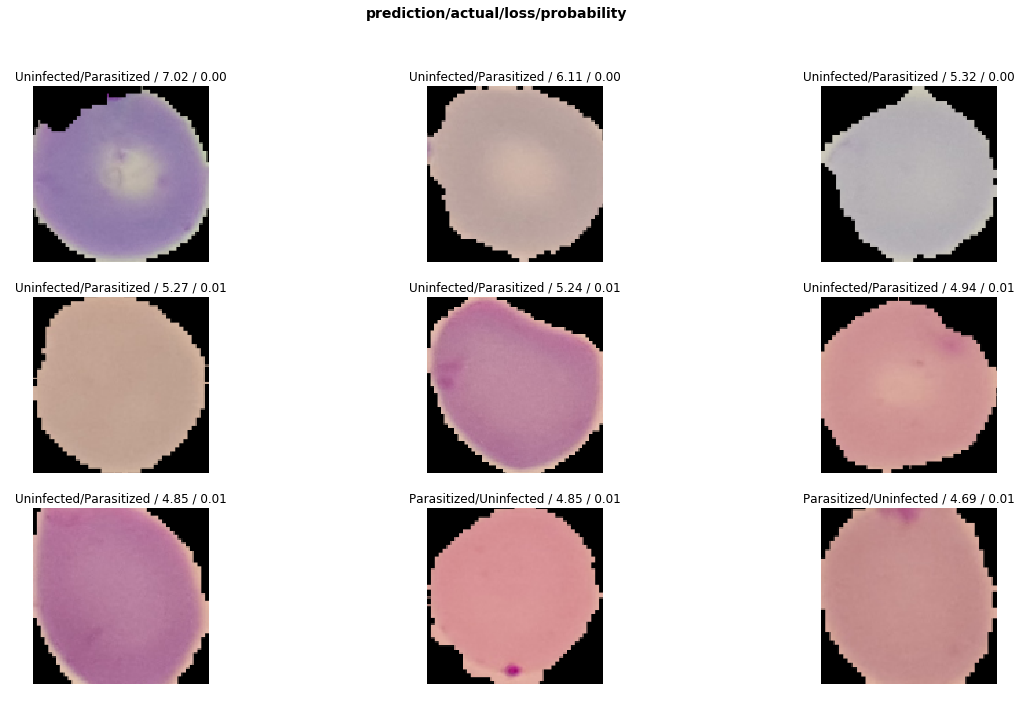

In [0]:
# look at the 9 worst results
interp.plot_top_losses(9, figsize=(20,11), heatmap=False)

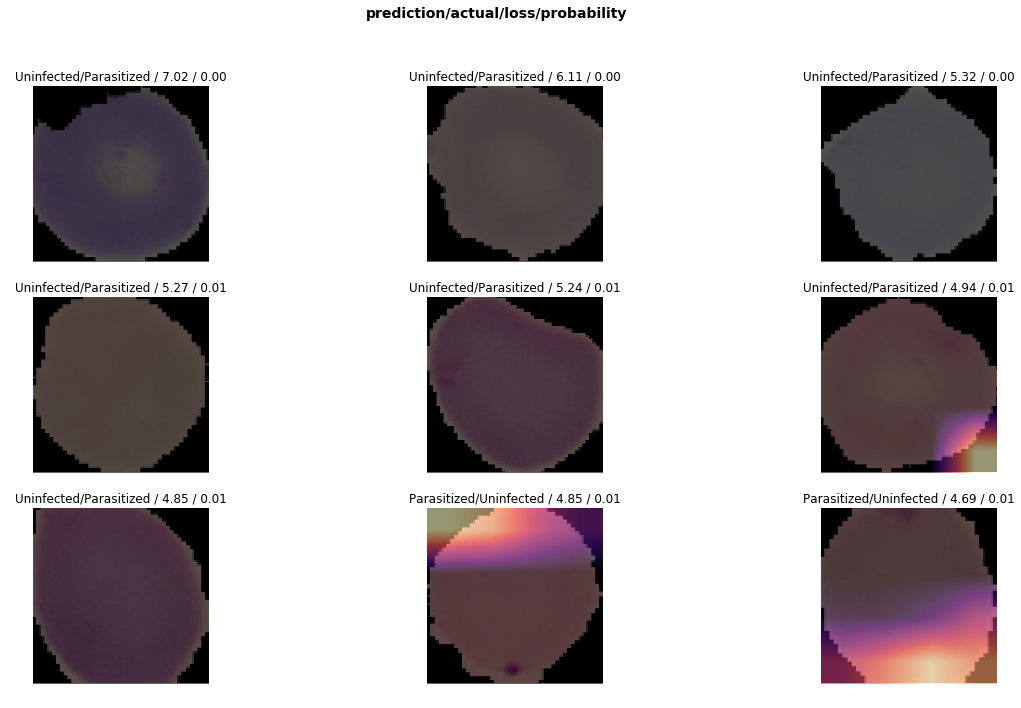

In [0]:
# look at the 9 worst results
interp.plot_top_losses(9, figsize=(20,11), heatmap=True)

## Inference


In [0]:
!mkdir /content/malaria/

mkdir: cannot create directory ‘/content/malaria/’: File exists


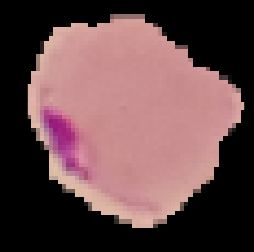

In [0]:
img = open_image('/content/malaria/malaria-infected-cell.png')
img

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category Parasitized

## Deployment
You can find various production solution [here](https://course.fast.ai/), section Production.

In [0]:
# Deploy
exportStageTo(learn, path)

# Fine-tuning a pre-trained model

Basically in a pretrained model you are freezing the earlier layers by making the weights unchangeable. This is so it can retain the already learned basic representations. 

By freezing the weights of many initial layers can significantly speed up network training. If the new data set is small, then freezing earlier network layers can also prevent those layers from overfitting to the new data set.

With fastai, when you  create a learner, it sets all BUT the last layer group to frozen. That means that the weights in the last layer group will be updated when we call `fit_one_cycle`.

Once you  have a good final layer group trained, we can proceed to  fine-tuning the other layer groups, by unfreezing the entire model, and using discriminative learning rates using a slice, so that the first layers are less trained as compare to the last layers. 

*NOTE:  Going straight to unfreeze the model.  is not recommended.  It has been tested that gradual unfreezing works better than unfreezing and retraining all layers of the network.*